In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG

from scipy.integrate import odeint, solve_ivp

seed = MasterRNG(42)

In [2]:
T_START = 0
T_END = 1
N_SAMPLES = 100
N_CURVES = 50
t = np.linspace(T_START, T_END, N_SAMPLES)

def ode_A(y, t, k):
    dydt = -k * y 
    return dydt

def ode_B(y, t, k):
    # dydt = - k * np.exp(0.5 * y) 
    dydt = - k * y**2 + 1 / (k * 0.5)
    return dydt

S = np.zeros((N_SAMPLES, N_CURVES))
U = np.zeros((N_SAMPLES, N_CURVES))
for i in range(N_CURVES):
    k = np.random.uniform(1, 3)
    # y0 = np.random.uniform(1, 3)
    y0=1
    
    if i<25:
        sol = odeint(ode_A, y0, t, args=(k,))
        U[:, i] = sol.flatten()
        S[:, i] = ode_A(sol, t, k).flatten()
    else:
        sol = odeint(ode_B, y0, t, args=(k,))
        U[:, i] = sol.flatten()
        S[:, i] = ode_B(sol, t, k).flatten()
        
print(S.shape, U.shape, t.shape)

(100, 50) (100, 50) (100,)


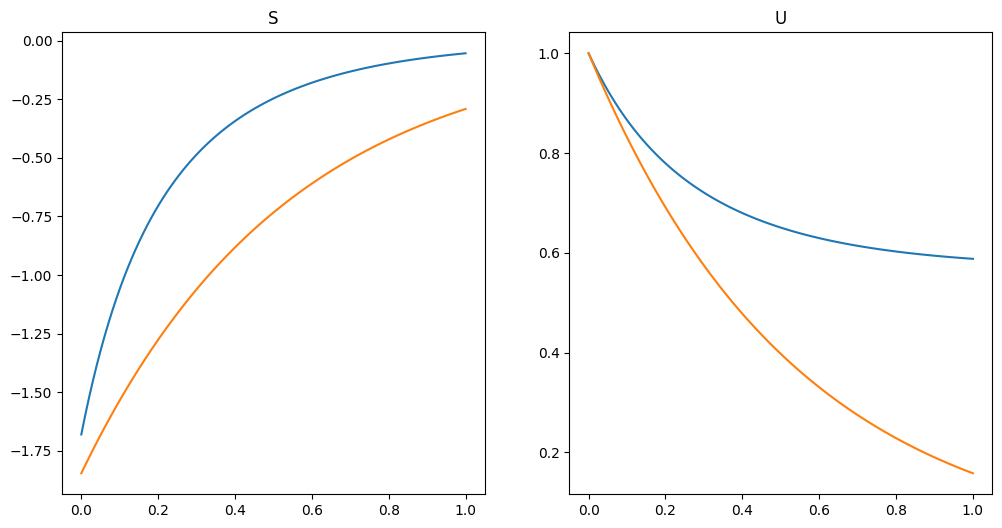

In [3]:
# Plot sample S and U
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, S[:,44])
plt.plot(t, S[:,12])
plt.title('S')
plt.subplot(1, 2, 2)
plt.plot(t, U[:,44])
plt.plot(t, U[:,12])
plt.title('U')
plt.show()

In [4]:
# us -> N_SAMPLES x N_CURVES = 800 ==> us (800, 80)
# ts -> (800, 1)
# ss -> (800, 1)

def iterate_data(m=N_SAMPLES, n=N_CURVES, x=t, U=U, S=S):
    us = np.zeros((m*n, m))
    ts = np.zeros((m*n, 1))
    ss = np.zeros((m*n, 1))
    for i in range(n):
        for j in range(m):
            us[i*m+j, :] = U[:, i]
            ts[i*m+j, :] = x[j]
            ss[i*m+j, :] = S[j, i]
    return us, ts, ss

us, ts, ss = iterate_data()
print(us.shape, ts.shape, ss.shape)

(5000, 100) (5000, 1) (5000, 1)


In [5]:
def batch_dataset(batch_size, m=N_SAMPLES, n=N_CURVES, x=t, U=U, S=S, ratio=0.9):
    us, xs, ss = iterate_data(m=m, n=n, x=x, U=U, S=S)
    
    train_size = int(len(us)*ratio)
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]
    
    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]
    
    us_train = torch.tensor(us_train, dtype=torch.float32)
    xs_train = torch.tensor(xs_train, dtype=torch.float32)
    ss_train = torch.tensor(ss_train, dtype=torch.float32)
    
    us_test = torch.tensor(us_test, dtype=torch.float32)
    xs_test = torch.tensor(xs_test, dtype=torch.float32)
    ss_test = torch.tensor(ss_test, dtype=torch.float32)
    
    train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = batch_dataset(batch_size=1024, ratio=0.9) 

# Check the shape of the data 
for u_batch, x_batch, s_batch in train_dataloader:
    print(u_batch.shape, x_batch.shape, s_batch.shape)
    break

torch.Size([1024, 100]) torch.Size([1024, 1]) torch.Size([1024, 1])


In [6]:
class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.in1 = in1
        self.in2 = in2
        self.neurons = neurons
        self.output_neurons = output_neurons
        
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()
        
    def branch_network(self):
        branch = nn.Sequential(
            nn.Linear(self.in1, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return branch
            
    def trunk_network(self):
        trunk = nn.Sequential(
            nn.Linear(self.in2, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return trunk
    
    def forward(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        x = torch.einsum("bi, bi->b", x1, x2)
        x = torch.unsqueeze(x, 1)
        return x

In [7]:
model = DeepONet(neurons=128, in1=N_SAMPLES, in2=1, output_neurons=20)

In [8]:
def loss(y_pred, y_true):
    return torch.mean((y_pred-y_true)**2)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
train_losses = []
epochs = 100

for i in range(epochs):
    l_total = 0
    for u_batch, x_batch, s_batch in train_dataloader:
        model.train()
        optimizer.zero_grad()
        y_pred = model(u_batch, x_batch)
        
        l = loss(y_pred, s_batch)   
        l_total += l.item()
        l.backward()    
        optimizer.step()
        
    l_total = l_total/len(train_dataloader)
    train_losses.append(l_total)
    
    if i % 10 == 0:
        print(f'Epoch {i}/{epochs}, Loss: {l_total}')  

Epoch 0/100, Loss: 0.5454691290855408
Epoch 10/100, Loss: 0.02097594700753689
Epoch 20/100, Loss: 0.01728611923754215
Epoch 30/100, Loss: 0.014450978860259056
Epoch 40/100, Loss: 0.011995220370590687
Epoch 50/100, Loss: 0.004439523350447417
Epoch 60/100, Loss: 0.002375927101820707
Epoch 70/100, Loss: 0.0012789679225534202
Epoch 80/100, Loss: 0.0007227562135085463
Epoch 90/100, Loss: 0.00043992346618324516


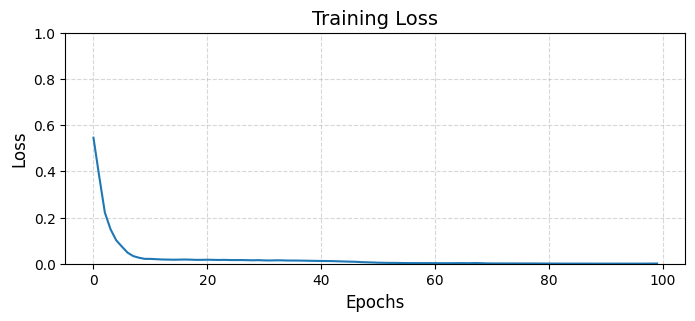

In [11]:
plt.figure(figsize=(8, 3))   
plt.plot(train_losses)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0, 1)
plt.title('Training Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

torch.Size([1, 100]) torch.Size([100, 1])
(100, 1)


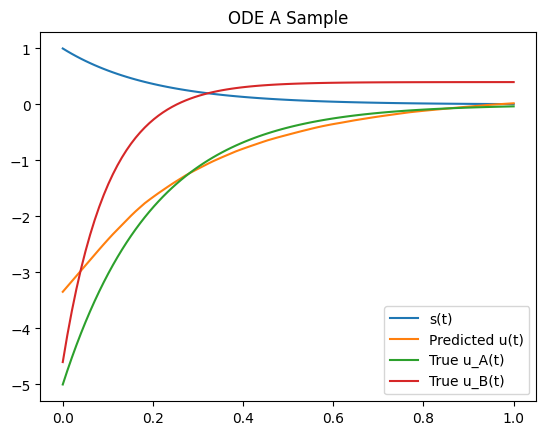

In [12]:
k = 5
y0 = 1

sol = odeint(ode_A, y0, t, args=(k,))
s_t = sol
u_t_A = ode_A(t=t, y=sol, k=k)
u_t_B = ode_B(t=t, y=sol, k=k)

s_t_tens = torch.tensor(s_t, dtype=torch.float32).T
t_test = torch.tensor(t, dtype=torch.float32).unsqueeze(1)
print(s_t_tens.shape, t_test.shape)

model.eval()
p = model(s_t_tens, t_test)
p = p.detach().numpy()
print(p.shape)

plt.plot(t, s_t, label='s(t)')
plt.plot(t, p, label='Predicted u(t)')
plt.plot(t, u_t_A, label='True u_A(t)')
plt.plot(t, u_t_B, label='True u_B(t)')
plt.title('ODE A Sample')
plt.legend()
plt.show()

torch.Size([1, 100]) torch.Size([100, 1])
(100, 1)


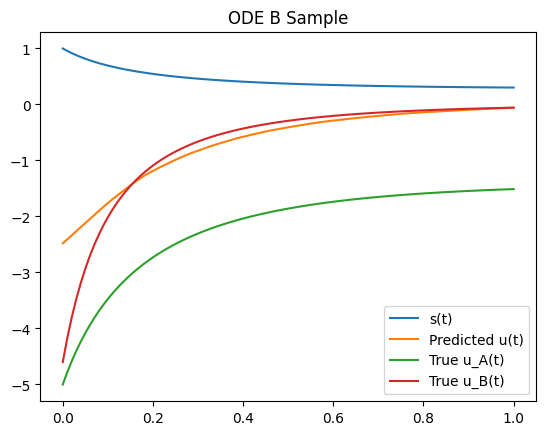

In [13]:
k = 5
y0 = 1

sol = odeint(ode_B, y0, t, args=(k,))
s_t = sol
u_t_A = ode_A(t=t, y=sol, k=k)
u_t_B = ode_B(t=t, y=sol, k=k)

s_t_tens = torch.tensor(s_t, dtype=torch.float32).T
t_test = torch.tensor(t, dtype=torch.float32).unsqueeze(1)
print(s_t_tens.shape, t_test.shape)

model.eval()
p = model(s_t_tens, t_test)
p = p.detach().numpy()
print(p.shape)

plt.plot(t, s_t, label='s(t)')
plt.plot(t, p, label='Predicted u(t)')
plt.plot(t, u_t_A, label='True u_A(t)')
plt.plot(t, u_t_B, label='True u_B(t)')
plt.title('ODE B Sample')
plt.legend()
plt.show()